## Equação de advecção/convecção

A equação de advecção linear fornece um exemplo simples para explorar equações hiperbólicas (como a equação de onda), e métodos numéricos para a sua resolução. Tem a forma:

$$ u_t +v u_x = 0,$$

onde $v$ representa a velocidade a que se propaga a informação.

Precisamos de condições iniciais:

$$  u(x,0) = u_0(x) ,$$

e de condições fronteira:

$$ u(0,t) =u_l(t) \quad \;\;\;\;  u(L,t) =u_r(t) $$

(como a equação é de primeira ordem, na verdade só vamos precisar de uma CF.)


A solução é trivial: qualquer forma inicial é simplesmente transladada para a direita (se $v>0$).
Assim $u(x-vt)$ é solução para qualquer forma inicial $u(x,0)$. A solução é constante ao longo das linhas $x-vt=\text{const}$.
Estas linhas são chamadas **características**.

Isto torna o problema de convecção um teste ideal:
* evoluir num domínio periódico
* comparar perfil original com o obtido após um período de propagação
* a diferença será o erro numérico


Usamos a notação $u_i^n$ para denotar o valor aproximado de $u$ no ponto da grelha espacial $i\Delta x$ no  instante  de tempo $n \Delta t$.

Escolhendo uma discretização das derivadas simples (para a frente no tempo, central no espaço, FTCS, que é primeira ordem no tempo, segunda ordem no espaço), temos:

$$ \frac{u_i^{n+1}- u_i^n}{\Delta t} = -v \frac{u_{i+1}^n - u_{i-1}^n}{2\Delta x} $$

Resolvendo em ordem ao único termo desconhecido no instante $(n+1)$:

$$  u_i^{n+1} =  u_i^n - \frac{C}{2}(u_{i+1}^n - u_{i-1}^n ) ,  $$

onde $C = v\Delta t / \Delta x$ é o número de Courant-Friedrichs-Lewy.

Como já vimos antes, para $i=0$ e $i=N_x-1$ (pontos extremos da grelha na notação do Python) são precisos pontos que não existem. Críamos assim pontos, chamados _fantasma_, em $i=-1$ e $i=N_x$, que terão valores obtidos a partir das condições fronteira. Aqui vamos escolher condições fronteira periódicas, pelo que:

$$ u_0^n = u_{N_{x}}^n  \;\;\;\; u_{N_x}^n = u_{0}^n  \;\;\;\; u_{-1}^n = u_{N_x-1}^n  .$$


Lembremos que a solução é apenas a translação para a direita da forma original

Vamos fazer um código que use CF periódicas, e comparar após um período. Num domínio $[0,1]$ o período é simplesmente $1/v$. Usamos um perfil inicial em degrau (cartola!).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from scipy import interpolate
%matplotlib inline

In [2]:
LNWDT=2; FNT=15
plt.rcParams['lines.linewidth'] = LNWDT;
plt.rcParams['font.size'] = FNT

a    = 1.0                    # velociade da onda
tmin, tmax = 0.0, 1.0         # tempo inicial e final da simulação
xmin, xmax = 0.0, 1.0         # início e fim do domínio espacial
Nx   = 65                     # número de pontos da grelha espacial
c    = 0.9                    # número de Courant , deve ser  c<=1 para ter estabilidade

init_func = 2          # Seleccionar função inicial degrau (0) , sin^2 (1), ou cartola (2)

# função que define condições iniciais
if (init_func==0):
    def f(x):
        """Atribui valor de 1.0 a todas as abcissas menores que 0.1"""
        f = np.zeros_like(x)
        f[np.where(x <= 0.1)] = 1.0
        return f
elif(init_func==1):
    def f(x):
        """Uma função suave sin^2 entre x_left e x_right"""
        f       = np.zeros_like(x)
        x_left  = 0.25
        x_right = 0.75
        xm      = (x_right-x_left)/2.0
        f       = where((x>x_left) & (x<x_right),\
                        np.sin(np.pi*(x-x_left)/(x_right-x_left))**4,f) 
        return f
elif(init_func==2):
    def f(x):
        """Uma função cartola entre x_left and x_right"""
        f       = np.zeros_like(x)
        x_left  = 0.25
        x_right = 0.75
        xm      = (x_right+x_left)/2.0
        width   = (x_right-x_left)/2.0
        f[np.where(abs(x-xm)< width)] = 1.0
        return f

In [3]:
def ftbs(u): # forward time backward space
    u[1:-1] = (1-c)*u[1:-1] + c*u[:-2]
    return u[1:-1]

def ftcs(u): # forward time centered space
    u[1:-1] = u[1:-1] - c/2*(u[2:] - u[:-2])
    return u[1:-1]

# Lax-Wendroff
def lax_wendroff(u): 
    u[1:-1] = c/2.0*(1+c)*u[:-2] + (1-c**2)*u[1:-1] - c/2.0*(1-c)*u[2:]
    return u[1:-1]

# Lax-Friedrich Advection
def lax_friedrich(u):
    u[1:-1] = (u[:-2] +u[2:])/2.0 -  c*(u[2:] - u[:-2])/2.0
    return u[1:-1] 

In [4]:
# Discretização
x    = np.linspace(xmin, xmax, Nx+1)  # discretização do espaço
dx   = float((xmax-xmin)/Nx)          # passo espacial
dt   = c/a*dx                         # passo temporal calculado do critério de estabilidade 
Nt   = int((tmax-tmin)/dt)            # número de passos no tempo
time = np.linspace(tmin, tmax, Nt)    # vector de instantes de tempo

In [5]:
solvers = [ftbs,lax_friedrich,lax_wendroff]
#solvers = [ftcs]

u_solutions = np.zeros((len(solvers),len(time),len(x)))
uanalytical = np.zeros((len(time), len(x))) # armazena a solução analítica

In [6]:
for k, solver in enumerate(solvers):     # Resolve para todos os solvers da lista
    u = f(x)
    un = np.zeros((len(time), len(x)))   # armazena a solução numérica

    for i, t in enumerate(time[1:]):
        
        if k==0:
            uanalytical[i,:] = f(x-a*t)  # calcula a solução analítica para este passo temporal
            
        u_bc = interpolate.interp1d(x[-2:], u[-2:]) # interpolar na fronteira direita
        
        u[1:-1] = solver(u[:])       # calcula a solução numérica nos pontos interiores
        u[-1] = u_bc(x[-1] - a*dt)   # interpola ao longo da característica para obter o valor na fronteira
        
        un[i,:] = u[:]               # armazena a solução para fazer gráfico
    
    u_solutions[k,:,:] = un

    

/Users/cauaveiga/miniforge3/envs/labs/lib/python3.9/site-packages/matplotlib/animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


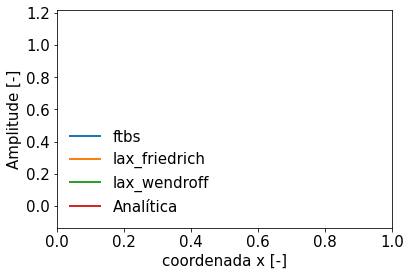

In [8]:
### Animação 
 
# Criar a figura, os eixos, e plot os elementos que queremos animar
fig  = plt.figure()
ax   = plt.axes( xlim = (xmin,xmax), ylim = (np.min(un), np.max(un)*1.1) )

lines = []     # list das linhas a representar para cada solução de solver e analítica
legends = []   # list para legendas para cada solução de solver, e analítica

for solver in solvers:
    line, = ax.plot([], [])
    lines.append(line)
    legends.append(solver.__name__)

line, = ax.plot([], []) # adiciona linha de plot adicional para a solução analítica
lines.append(line)
legends.append('Analítica')

plt.xlabel('coordenada x [-]')
plt.ylabel('Amplitude [-]')
plt.legend(legends, loc=3, frameon=False)
 
# inicializa a função: plot do fundo de cada frame
def init():
    for line in lines:
        line.set_data([], [])
    return lines,

# função de animação. É chamada  sequencialmente
def animate(i):
    for k, line in enumerate(lines):
        if (k==0):
            line.set_data(x, un[i,:])
        else:
            line.set_data(x, uanalytical[i,:])
    return lines,

def animate_alt(i):
    for k, line in enumerate(lines):
        if (k==len(lines)-1):
            line.set_data(x, uanalytical[i,:])
        else:
            line.set_data(x, u_solutions[k,i,:])
    return lines,

 
# chama o animador.  blit=True significa que apenas re-desenhamos partes que mudaram.
anim = animation.FuncAnimation(fig, animate_alt, init_func=init, frames=Nt, interval=100, blit=False)

plt.show()

Evolução com N=65, C=0.9, após 1 período:
<img src="../imagens/advec_01.png" alt="Upwinding" width="350"/>
Note a escala vertical!!!!
não se vê nada parecido como perfil inicial!
O que se passa?

Reduzir o passo temporal é equivalente a reduzir o número CFL:

<img src="../imagens/advec_02.png" alt="Upwinding" width="350"/>
CFL = 0.1, ainda 1 período completo.
A escala foi muito reduzida, mas ainda é mau.

Vejamos como estas características se desenvolvem.


Se evoluírmos por apenas $1/10$ de período:
<img src="../imagens/advec_03.png" alt="Upwinding" width="350"/>
CFL = 0.1
Note que as oscilações aparecem perto das descontinuidades.
Até aqui estudamos o passo no tempo. E que tal a resolução?

Agora com 251 pontos:
<img src="../imagens/advec_04.png" alt="Upwinding" width="350"/>
Parece que o problema não é com a condição de CFL, mas algo mais profundo.

Considere uma solução que consiste apenas num modo de Fourier:

$$u_i^n = A^n e^{jik\Delta x}$$

(como equação é linear basta tratar um modo).

Estabilidade exige que:

$$ \left|\frac{A^{n+1}}{A^{n}} \right| \le 1 $$

que substituído na nossa equação às diferenças finitas conduz a:

$$ \left|\frac{A^{n+1}}{A^{n}} \right|^2 = 1+C^2\sin^2\theta \ge 1 $$

* Note que não há dependência em n: todos os modos crescem da mesma maneira
* Não há valor de $C$ que permita estabilidade.

FTCS é **incondicionalmente instável**!

Observação:

> Finite-difference methods solve linear advection equations
approximately, but they solve _modified_ linear advection
equations exactly!

Vejamos então que equação é que a nossa equação de diferenças finitas aproxima.

Substituímos:

$$ u_i^{n+1} = u_i^{n} + \dot{u}\Delta t + \frac{1}{2}\ddot{u}(\Delta t)^2+ \mathcal{O}(\Delta t)^3 $$

e

$$u_{i\pm 1}^{n} = u_i^{n} \pm u_x\Delta x + \frac{1}{2}u_{xx}(\Delta x)^2+ \mathcal{O}(\Delta x)^3 .$$

Eventualmente chegamos à equação:
$$ u_t +vu_x = \color{red}{-\frac{1}{2}\Delta t v^2 u_{xx} }  $$

Estamos a resolver um problema com  advecção e difusão (termo a vermelho)! Mas a difusão tem sinal negativo! Assim características suaves são transformadas em oscilações rápidas, o que é não-físico!

A presença de difusão numérica  é comum em esquemas de diferenças finitas, mas o seu resultado deve ser físico.


### Upwinding

Voltemos à equação original e tentemos uma discretização diferente: em vez de diferenças centrais (2ª ordem) no espaço vamos tentar 1ª ordem.

Há duas possibilidades:

$$  \underbrace{u_{x} = \frac{u_i^{n} -u_{i-1}^{n}}{\Delta x}}_{\text{ upwind}} \;\;\;\;\;\; \underbrace{u_{x} = \frac{u_{i+1}^{n} -u_{i}^{n}}{\Delta x}}_{\text{ downwind}}$$

Tentemos a _upwind_. Vem:

$$ u_i^{n+1} =  u_i^{n} -C (u_i^{n} -u_{i-1}^{n}) $$

Solução _Upwinding_ com N = 65, C = 0.9, após 1 período
<img src="../imagens/advec_05.png" alt="Upwinding" width="350"/>

Muito melhor que o que tínhamos antes! Ainda há erros mas pelo menos não é instável. O efeito da difusão numérica é evidente.

Note que se tomarmos $C=1$  obtemos uma translação exacta dos dados para a célula ao lado.

$$ u_i^{n+1} =  u_i^{n} - (u_i^{n} -u_{i-1}^{n})= u_{i-1}^{n} $$

Mas para equações não-lineares, ou para sistemas de equações de advecção, em geral não é possível fazer 
$C = 1$, porque não existe uma velocidade única na grelha!

### Análise da estabilidade da equação _upwinded_

Fazendo uma análise semelhante à que fizémos atrás com um único modo de Fourier, obtemos a condição:

$$ \left|\frac{A^{n+1}}{A^{n}} \right|^2 = 1-2C(1-C)(1-\cos\theta) \le 1 $$

O termo $(1-\cos\theta) \ge 0$ sempre, pelo que precisamos que $2C(1-C) \ge 0$, o que conduz a $0 \le C \le 1$ como condição para a estabilidade do método _upwind_.

Isto quer dizer que a informação não se pode propagar mais que uma célula por passo temporal.

É uma restrição muito comum em PDEs hiperbólicas (já a vimos na equação de onda de 2ª ordem).

A análise por truncagem das séries de Taylor (como atrás para a FTCS) levam à conclusão que este método é equivalente à equação:

$$ u_t + vu_x = -\frac{1}{2}v \Delta x (1-C) u_{xx} ,$$

que representa difusão física se $1-C > 0$. Também mostra que obtemos a solução exacta se $C=1.$

Se usássemos o esquema _downwind_ o método seria incondicionalmente instável! Na realidade a direcção a escolher está relacionada com o sinal da velocidade. Fisicamente, a nossa escolha (_upwind_) diz que usamos a informação que vem do lado do qual sopra o vento (o método teve origem em estudos para previsão metereológica!).

Examinar o quociente das partes imaginária e real do modo de Fourier também nos diz se o método introduz atrasos de fase. Nalguns métodos pode ser elevada!

## Outros métodos

### Lax-Friedrichs:
Começa com FTCS, mas substitui $u_i^n \rightarrow \frac{1}{2}(u_{i-1}^n + u_{i+1}^n )$. Obtemos:

$$ u_i^{n+1} = \frac{1}{2}(1+C)u_{i-1}^n  +  \frac{1}{2}(1-C)u_{i+1}^n .$$

É estável se $C<1$, mas não contém o ponto que queremos actualizar! 
Pode sofrer de desacoplamento par-ímpar. Pode ser mais difusivo que 
_upwinding_ ( e piora quando $C$ decresce!)

### Lax-Wendroff
Aqui calculamos $u_i^{n+1}$ baseado na informação no meio passo

$$u^{n+1/2}_i=u^{n}_i+\frac{\Delta t}{2}\left( \left.-v\frac{\partial u}{\partial x}\right|_{i}^j\right)$$

$$u^{n+1}_i=u^{n}_i+\frac{\Delta t}{2}\left( \left.-v\frac{\partial u}{\partial x}\right|_{i}^{j+1/2}\right).$$

Para aproximar a derivada $ (u_x)_{i}^{j+1/2} $ usamos diferenças centrais:

$$ u^{n+1}_i=u^{n}_i -\frac{v\Delta t}{\Delta x}\left(u_{i+1/2}^{j+1/2} - u_{i-1/2}^{j+1/2}\right).$$

No segundo passo ambas as quantidades $u_{i\pm 1/2}^{j+1/2}$ podem ser calculadas usando o método de Lax-Friedrichs. Como resultado obtemos o esquema de dois passos:

$$ u_{i- 1/2}^{n+1/2} = \frac{1}{2}\left(u_{i}^{n} + u_{i-1}^{n}\right)-\frac{v\Delta t}{2\Delta x} \left(u_{i}^{n} - u_{i-1}^{n}\right)$$

$$ u_{i+ 1/2}^{n+1/2} = \frac{1}{2}\left(u_{i+1}^{n} + u_{i}^{n}\right) -\frac{v\Delta t}{2\Delta x} \left(u_{i+1}^{n} - u_{i}^{n}\right)$$

$$ u_{i}^{n+1} = u_{i}^{n} -\frac{v\Delta t}{\Delta x} \left(u_{i+1/2}^{n+1/2} - u_{i-1/2}^{n+1/2}\right).$$

Este esquema pode ser reescrito como:
$$  u_{i}^{j+1} = b_{-1}u_{i-1}^{j} + b_{0}u_{i}^{j} +b_{1}u_{i+1}^{j},$$
onde as constantes $b_k$ são dadas por:

$$ b_{-1} = \frac{C}{2}(C+1) \;\;\;\;\;\; b_{0}= 1-C^2 \;\;\;\;\;\; b_{1} = \frac{C}{2}(C-1)$$

onde de novo $C$ é o número CFL. A matriz correspondente aos coeficientes do sistema linear é tridiagonal circulante (devido às condições fronteira).

O esquema de 3 pontos é de segunda ordem no tempo e no espaço. Na realidade, para a equação de advecção linear é o único esquema explícito de precisão de segunda ordem tanto no tempo como no espaço.

### Método de Lax-Wendroff para equações de conservação em 1D

Uma equação de evolução típica tem a forma:

$$ \frac{\partial u}{\partial t} + \frac{\partial F(u)}{\partial x}=0,$$

onde $u=u(x,t)$ e $F(u)$ depende do problema em causa.
Podemos aplicar o método de Lax-Wendroff. Com $F_{i}^{j}:=F(u_{i}^{j})$ temos o esquema seguinte:

$$ u_{i- 1/2}^{j+1/2} = \frac{1}{2}\left(u_{i}^{j} + u_{i-1}^{j}\right)-\frac{\Delta t}{2\Delta x} \left(F_{i}^{j} - F_{i-1}^{j}\right)$$
$$ u_{i+ 1/2}^{j+1/2} = \frac{1}{2}\left(u_{i+1}^{j} + u_{i}^{j}\right) -\frac{\Delta t}{2\Delta x} \left(F_{i+1}^{j} - F_{i}^{j}\right)$$
$$ u_{i}^{j+1} = u_{i}^{j} -\frac{\Delta t}{\Delta x} \left(F_{i+1/2}^{j+1/2} - F_{i-1/2}^{j+1/2}\right).$$